In [1]:
import csv

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [2]:
#dataset_joren = 'camara_data/hand_landmarks_joren_family.csv'
#dataset_joren_grandparents = 'camara_data/hand_landmarks_moeke.csv'
dataset_testGood = 'camera_data_test/hand_landmarks_goodTest.csv'
dataset_testBad = 'camera_data_test/hand_landmarks_badTest.csv'
dataset_testDark = 'camera_data_test/hand_landmarks_darkTest.csv'
dataset_hand_after_sign= 'camera_data_test/hand_landmarks_hand_behind_hand.csv'
model_save_path = 'new_hand_classifier.keras'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [4]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1))))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data, axis=0)
X_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_test_hand_behind = np.loadtxt(dataset_hand_after_sign, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
y_dataset = np.concatenate(data, axis=0)
y_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='int32', usecols=(0))
y_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='int32', usecols=(0))
y_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='int32', usecols=(0))
y_test_hand_behind = np.loadtxt(dataset_hand_after_sign, delimiter=',', dtype='float32', usecols=(0))

In [6]:
print("X_dataset shape: " + X_dataset.shape.__str__())
print("y_dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X_test_dataset_good shape: " + X_testGood.shape.__str__())
print("y_test_dataset_good shape: " + y_testGood.shape.__str__())
print("----------------------------------")
print("X_test_dataset_bad shape: " + X_testBad.shape.__str__())
print("y_test_dataset_bad shape: " + y_testBad.shape.__str__())
print("----------------------------------")
print("X_test_dataset_dark shape: " + X_testDark.shape.__str__())
print("y_test_dataset_dark shape: " + y_testDark.shape.__str__())


X_dataset shape: (26399, 42)
y_dataset shape: (26399,)
----------------------------------
X_test_dataset_good shape: (2400, 42)
y_test_dataset_good shape: (2400,)
----------------------------------
X_test_dataset_bad shape: (2400, 42)
y_test_dataset_bad shape: (2400,)
----------------------------------
X_test_dataset_dark shape: (2400, 42)
y_test_dataset_dark shape: (2400,)


In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [8]:
print(X_train)

[[ 0.          0.          0.13946587 ... -0.6706231  -0.3620178
  -0.79821956]
 [ 0.          0.         -0.26041666 ... -0.6197917  -0.47916666
  -0.49739584]
 [ 0.          0.          0.2993197  ... -0.585034    0.30612245
  -0.4727891 ]
 ...
 [ 0.          0.          0.21645021 ... -0.47619048 -0.08658009
  -0.4025974 ]
 [ 0.          0.         -0.1891892  ... -0.5243243  -0.42162162
  -0.45945945]
 [ 0.          0.          0.129771   ... -0.37150127 -0.09160306
  -0.30025446]]


# Model building

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)

# Get feature scores
feature_scores = selector.scores_

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Print feature scores and their corresponding indices
for i, score in enumerate(feature_scores):
    if i in selected_indices:
        print(f"Feature {i}: Score = {score}")

Feature 0: Score = nan
Feature 1: Score = nan
Feature 2: Score = 0.9592323303222656
Feature 3: Score = 1203.2501220703125
Feature 4: Score = 2.0095818042755127
Feature 5: Score = 1506.9266357421875
Feature 6: Score = 2.996534824371338
Feature 7: Score = 1669.0810546875
Feature 8: Score = 3.3382956981658936
Feature 9: Score = 1718.2596435546875
Feature 10: Score = 7.94464635848999
Feature 11: Score = 834.2915649414062
Feature 12: Score = 5.066037654876709
Feature 13: Score = 1591.3648681640625
Feature 14: Score = 3.651585102081299
Feature 15: Score = 2204.60546875
Feature 16: Score = 3.5164573192596436
Feature 17: Score = 2903.919921875
Feature 18: Score = 15.926277160644531
Feature 19: Score = 724.853515625
Feature 20: Score = 8.172597885131836
Feature 21: Score = 1820.3118896484375
Feature 22: Score = 5.4311203956604
Feature 23: Score = 2606.059814453125
Feature 24: Score = 5.004454612731934
Feature 25: Score = 3333.416015625
Feature 26: Score = 20.67281723022461
Feature 27: Score = 7

C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 21, 2, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 21, 2, 32)         128       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 2, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 2, 64)         6208      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 2, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 2, 128)         2

In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


144/145 [============================>.] - ETA: 0s - loss: 1.9124 - accuracy: 0.4002
Epoch 1: saving model to new_hand_classifier.keras
145/145 [==============================] - 10s 38ms/step - loss: 1.9100 - accuracy: 0.4009 - val_loss: 0.6029 - val_accuracy: 0.8088
Epoch 2/1000
144/145 [============================>.] - ETA: 0s - loss: 0.5684 - accuracy: 0.8115
Epoch 2: saving model to new_hand_classifier.keras
145/145 [==============================] - 5s 36ms/step - loss: 0.5680 - accuracy: 0.8115 - val_loss: 0.2854 - val_accuracy: 0.9008
Epoch 3/1000
145/145 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8887
Epoch 3: saving model to new_hand_classifier.keras
145/145 [==============================] - 6s 44ms/step - loss: 0.3278 - accuracy: 0.8887 - val_loss: 0.1668 - val_accuracy: 0.9543
Epoch 4/1000
144/145 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9289
Epoch 4: saving model to new_hand_classifier.keras
145/1

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size=128)

19/19 [==============================] - 0s 5ms/step - loss: 0.2494 - accuracy: 0.9567


In [16]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testBad, y_testBad, batch_size=128)

19/19 [==============================] - 0s 6ms/step - loss: 2.3572 - accuracy: 0.7983


In [17]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testDark, y_testDark, batch_size=128)

19/19 [==============================] - 0s 6ms/step - loss: 1.3667 - accuracy: 0.8758


In [18]:
val_loss, val_acc = model.evaluate(X_test_hand_behind, y_test_hand_behind, batch_size=128)

10/10 [==============================] - 0s 7ms/step - loss: 6.3730 - accuracy: 0.6358


In [21]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [22]:
# Inference test
predict_result = model.predict(np.array([X_testGood[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[1.0000000e+00 0.0000000e+00 2.1150818e-35 1.2456809e-35 0.0000000e+00
 0.0000000e+00 2.6579278e-30 4.4830978e-35 0.0000000e+00 2.3780996e-32
 7.4209308e-35 1.3341995e-20 5.8246342e-31 5.0556335e-29 2.7456418e-28
 6.8557140e-24 1.8922653e-24 0.0000000e+00 2.9482930e-38 3.9227595e-21
 0.0000000e+00 0.0000000e+00 2.1766132e-32 1.3201995e-22 8.2376337e-19
 7.4553204e-35]
0


# Confusion matrix

75/75 [==============================] - 0s 3ms/step


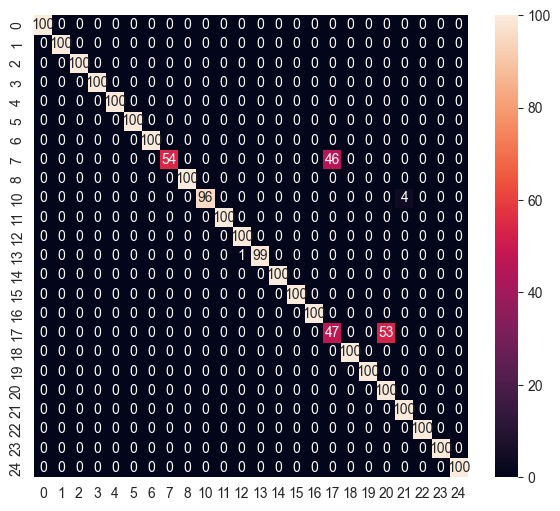

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      0.54      0.70       100
           8       1.00      1.00      1.00       100
          10       1.00      0.96      0.98       100
          11       1.00      1.00      1.00       100
          12       0.99      1.00      1.00       100
          13       1.00      0.99      0.99       100
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00       100
          16       1.00      1.00      1.00       100
          17       0.51      0.47      0.49       100
     

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_testGood, y_pred))

Y_pred = model.predict(X_testGood)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_testGood, y_pred)

# Convert to model for Tensorflow-Lite

In [22]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [20]:
tf.saved_model.save(model, "testkeras")

INFO:tensorflow:Assets written to: testkeras\assets


INFO:tensorflow:Assets written to: testkeras\assets


In [29]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpbapjtk46\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpbapjtk46\assets


# Inference test

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [23]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [24]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_testGood[0]]))

In [25]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 8 ms


In [26]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0000000e+00 0.0000000e+00 1.6815582e-44 7.2029656e-34 0.0000000e+00
 0.0000000e+00 9.6592480e-26 2.6977270e-21 1.3217301e-31 3.8373157e-41
 2.5493153e-31 5.1290803e-14 2.8025969e-45 1.1352142e-34 8.8715286e-28
 5.6871692e-30 4.4420978e-23 5.3529601e-43 1.2874377e-32 3.2445824e-15
 3.9761788e-38 0.0000000e+00 1.1588738e-42 3.4389885e-20 9.9741776e-22
 1.8397090e-38]
0


In [28]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

ValueError: The following argument(s) are not supported with the native Keras format: ['include_optimizer']

#### Loss  (cost)

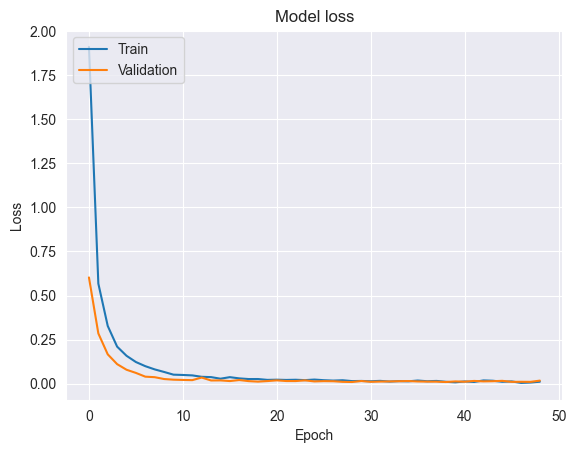

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

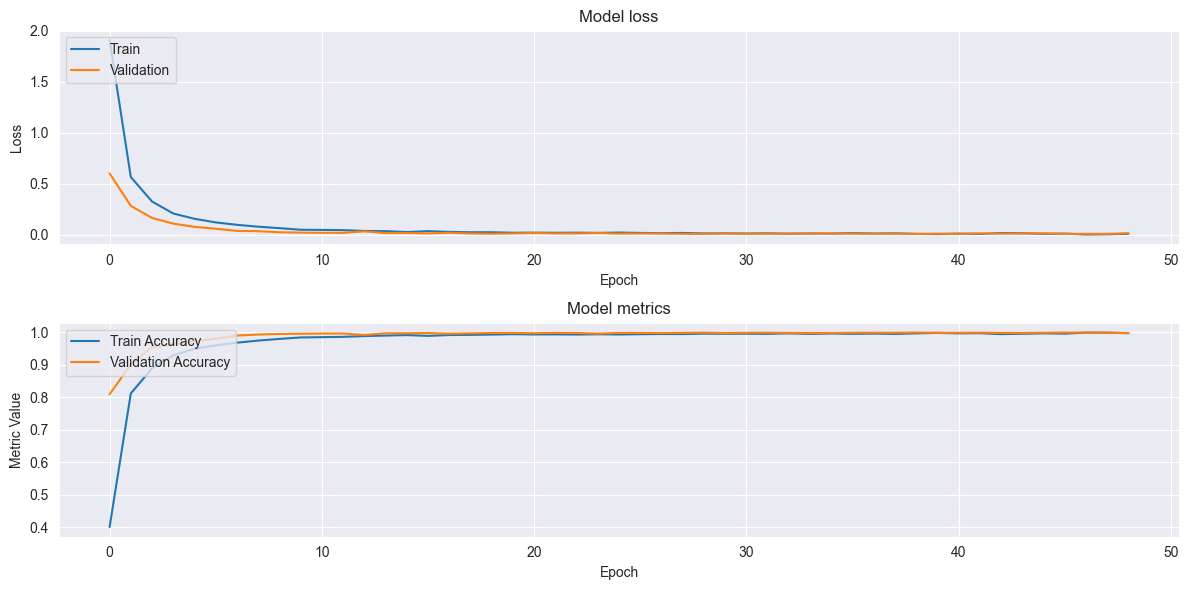

In [31]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

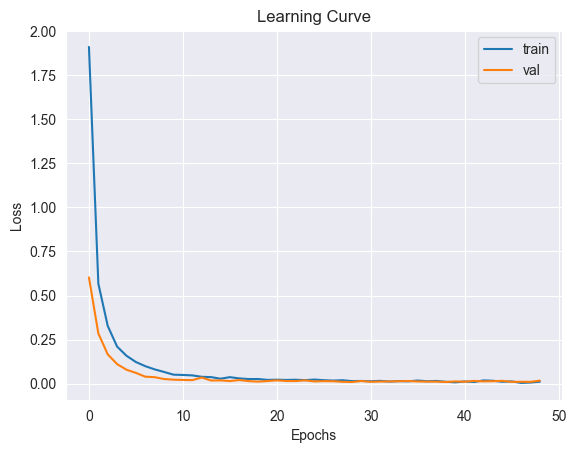

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()